# ENSF 519.01 Applied Data Science 
**Assignment 2** - 100 marks

**Due:** October 18th, 04.00 pm.


**IMPORTANT NOTE: each task must be implemented as asked, even if there are other easier or better solutions.**

**How to deliver:**
Edit this file and write your solutions in sections specified with `# Your solution`. Test your code and when you are done, submit this notebook as an `.ipynb` file to D2L dropbox. 



## Problem 1 - Most popular movies (55 points)
In this assigment we want to do some basic data analysis on the most popular movies on IMDb right now. We do this in steps: first we take the list of most popular movies then we gather more informaion on each movie from the movie's page. These info are stored in pandas dataframes. Next we need to combine the information from these two tables, using pandas `merge` method. The resulting merged table might give us some insight on why some movies get more popular. Let's try and see what we can get!

Complete the `get_page_html` function below so that it gets the HTML content of any given url. We get the HTML content and store it in a variable just once, because:
1. Downloading the web page content takes ~1-2 seconds. While you're writing the html parser code you need to run and test your code many many times. If you download the whole page everytime you want to test the parser, these download times add up to significantly slow you down.
2. Making a lot of requests to the same page of a website in a short period of time might make the firewall suspicious of an attack and block your IP address

In [211]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

page_url = 'https://www.imdb.com/chart/top'

def get_page_html(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.content.decode()
    else:
        print("Error.")
    
top_movies_html = get_page_html(page_url)

Parse the HTML content above using Beautiful Soup to extract these data:

* Rank (`rank`: int) **set this column as the index**
* Name of the movie (`name`: str) 
* Its release year (`release_year`: int)
* Rating (`rating`: float)
* link to its detail page (`detail_url`: str)

Store these in a pandas dataframe. The suggested column names and data types are specified in the parentheses above (20 points).

In [3]:
import re
def get_top_movies(top_movies_page_html):
    # init variables
    parser = BeautifulSoup(top_movies_page_html, 'html.parser')
    
    # get movie list
    movie_list = parser.find("tbody", class_="lister-list")
    
    # find all movies in the list
    movie_array = []
    movies = movie_list.find_all("tr")
    for i in movies:
        movie_attributes = list(filter(lambda tag: tag != "\n", list(i.children)))
        
        # get the rank
        title_column = list(filter(lambda content: content != "\n", movie_attributes[1].contents))
        rank = int(re.findall("[0-9]+", title_column[0].strip())[0])
        
        # get the name
        movie_name = str(title_column[1].text.strip())
        
        # get the release year
        release_year = int(re.findall("[0-9]+", title_column[2].text.strip())[0])
        
        # get the rating
        rating = float(movie_attributes[2].text.strip())
        
        # get the line to it's detail page
        detail_page_link = str("https://www.imdb.com" + title_column[1].attrs['href'])
        
        # add to movie array
        movie_array.append([rank, movie_name, release_year, rating, detail_page_link])
        
     # return movie array as pandas dataframe
    return pd.DataFrame(movie_array, columns = ["rank", "movie_name", "release_year", "rating", "detail_url"])
    
        
top_movies = get_top_movies(top_movies_html)
top_movies  # Rank must be the index, the rows should match the webpage

,rank,movie_name,release_year,rating,detail_url
0,1,The Shawshank Redemption,1994,9.2,https://www.imdb.com/title/tt0111161/
1,2,The Godfather,1972,9.1,https://www.imdb.com/title/tt0068646/
2,3,The Godfather: Part II,1974,9.0,https://www.imdb.com/title/tt0071562/
3,4,The Dark Knight,2008,9.0,https://www.imdb.com/title/tt0468569/
4,5,12 Angry Men,1957,8.9,https://www.imdb.com/title/tt0050083/
...,...,...,...,...,...
245,246,Mou gaan dou,2002,8.0,https://www.imdb.com/title/tt0338564/
246,247,Aladdin,1992,8.0,https://www.imdb.com/title/tt0103639/
247,248,La battaglia di Algeri,1966,8.0,https://www.imdb.com/title/tt0058946/
248,249,Drishyam,2015,8.0,https://www.imdb.com/title/tt4430212/


Now we proceed to step 2, we want to create a function that parses each individual movie's page. Just like the previous assignment on regular expressions, we try to get that working on one sample and only after we made sure that everything works properly we use a loop to get all the data that we need. 

In [5]:
avengers_url = 'https://www.imdb.com/title/tt4154796/'
avengers_html = get_page_html(avengers_url)

Make a function that parses the html content of a movie details page and extracts these information:

* Movie length in minutes (int)
* Release date (convert the string to a python date object - use [`strptime` built-in function](https://www.programiz.com/python-programming/datetime/strptime) or regular expressions as you wish)
* List of genres (list of strings)
* Budget (int), if unavailable: ignore.
* Name of the directors (list)

Return these as a dictionary. You can extract more data as you wish. (20 points)

In [212]:
import re
from datetime import datetime 

def extract_movie_details(html):
    parser = BeautifulSoup(html, 'html.parser')

     # get title wrapper peices as a string
    title_bar = parser.find("div", class_="title_wrapper")
    title_subtext = title_bar.find("div", class_="subtext")
    subtext_pieces = list(filter(lambda tag: tag != "\n" \
                                 and str(type(tag)) != '<class \'bs4.element.NavigableString\'>', \
                                 list(title_subtext.children)))
            
    genre_list = []
    movie_length = 0
    for subtext_tags in subtext_pieces:
        # Get movie length
        if 'datetime' in subtext_tags.attrs.keys():
            movie_length = int(re.findall("[0-9]+", subtext_tags.attrs["datetime"])[0])
        elif 'href' in subtext_tags.attrs.keys():
            # List of genres (list of strings)
            if "genres" in subtext_tags["href"]:
                genre_list.append(subtext_tags.text.lower())
            # Release date
            elif "releaseinfo" in subtext_tags["href"]:
                try:
                    release_date = subtext_tags.text.strip()
                    release_date = re.findall("^(.+) \(.+\)", release_date)[0]
                    date_object = datetime.strptime(release_date, "%d %B %Y")
                except:
                    date_object = None

    # Get Budget (int), if unavailable: ignore.
    budget = None
    txt_blocks = parser.find_all("div", class_="txt-block")
    for txt_block in txt_blocks:
        h4_blocks = txt_block.find_all("h4")
        if len(h4_blocks) > 0:
            if h4_blocks[0].text == "Budget:":
                budget_list = re.findall("[0-9]+", txt_block.text)
                budget = int("".join(budget_list))
            
    # Get Name of the directors (list)
    directors = []
    plot_summary = parser.find("div", class_="plot_summary")
    director_block = plot_summary.find_all("div", class_="credit_summary_item")[0]
    director_tags = director_block.find_all("a")
    for director in director_tags:
        directors.append(director.text.strip())
    
    return {'length': movie_length, \
            'genres': genre_list, \
            'release_date': date_object, \
            'budget': budget, \
            'directors': directors
           }
    
    
avengers_data = extract_movie_details(avengers_html)
print(avengers_data) 
# Expected: {
#     'length': 181, 
#     'genres': ['action', 'adventure', 'sci-fi'], 
#     'release_date': datetime.datetime(2019, 4, 26, 0, 0),
#     'budget': 356000000,
#     'directors': ['Anthony Russo', 'Joe Russo']
# }

{'length': 181, 'genres': ['action', 'adventure', 'sci-fi'], 'release_date': datetime.datetime(2019, 4, 26, 0, 0), 'budget': 356000000, 'directors': ['Anthony Russo', 'Joe Russo']}


Now get the list of detail page urls for all the movies:

In [7]:
urls = top_movies.set_index('movie_name')['detail_url']
urls

movie_name
The Shawshank Redemption    https://www.imdb.com/title/tt0111161/
The Godfather               https://www.imdb.com/title/tt0068646/
The Godfather: Part II      https://www.imdb.com/title/tt0071562/
The Dark Knight             https://www.imdb.com/title/tt0468569/
12 Angry Men                https://www.imdb.com/title/tt0050083/
                                            ...                  
Mou gaan dou                https://www.imdb.com/title/tt0338564/
Aladdin                     https://www.imdb.com/title/tt0103639/
La battaglia di Algeri      https://www.imdb.com/title/tt0058946/
Drishyam                    https://www.imdb.com/title/tt4430212/
Tenkû no shiro Rapyuta      https://www.imdb.com/title/tt0092067/
Name: detail_url, Length: 250, dtype: object

and loop through the movie name and urls created above (`urls`), use `extract_movie_details` and create a data frame out of the dictionaries. The dataframe should have a column storing the movie name and one column for each item in the dictionary (length, genres, ...). If any piece of data was not availble for a movie (e.g. budget might not be available for some) just leave it, pandas will use `NaN` for that cell. (10 points)

In [8]:
movie_details = []
for name, url in urls.items():
    html = get_page_html(url)
    movie_details_dict = extract_movie_details(html)
    movie_details_dict['movie_name'] = name
    movie_details.append(movie_details_dict)

In [9]:
movie_details_df = pd.DataFrame(movie_details)

In [154]:
movie_details_df.to_csv('movie_details.csv')

In [10]:
movie_details_df

,length,genres,release_date,budget,directors,movie_name
0,142,[drama],1994-10-14,25000000.0,[Frank Darabont],The Shawshank Redemption
1,175,"[crime, drama]",1972-03-24,6000000.0,[Francis Ford Coppola],The Godfather
2,202,"[crime, drama]",1974-12-20,13000000.0,[Francis Ford Coppola],The Godfather: Part II
3,152,"[action, crime, drama]",2008-07-18,185000000.0,[Christopher Nolan],The Dark Knight
4,96,[drama],1957-04-10,350000.0,[Sidney Lumet],12 Angry Men
...,...,...,...,...,...,...
245,101,"[crime, drama, mystery]",2002-12-12,6428966.0,"[Andrew Lau, Alan Mak]",Mou gaan dou
246,90,"[animation, adventure, comedy]",1992-12-25,28000000.0,"[Ron Clements, John Musker]",Aladdin
247,121,"[drama, war]",1967-02-25,800000.0,[Gillo Pontecorvo],La battaglia di Algeri
248,163,"[crime, drama, mystery]",2015-07-31,9400000.0,[Nishikant Kamat],Drishyam


Use pandas' `merge` method to join these two tables into one. Merge on movie name. (5 points)

In [11]:
merged = pd.merge(
    top_movies,
    movie_details_df,
    on = "movie_name"
)
merged

,rank,movie_name,release_year,rating,detail_url,length,genres,release_date,budget,directors
0,1,The Shawshank Redemption,1994,9.2,https://www.imdb.com/title/tt0111161/,142,[drama],1994-10-14,25000000.0,[Frank Darabont]
1,2,The Godfather,1972,9.1,https://www.imdb.com/title/tt0068646/,175,"[crime, drama]",1972-03-24,6000000.0,[Francis Ford Coppola]
2,3,The Godfather: Part II,1974,9.0,https://www.imdb.com/title/tt0071562/,202,"[crime, drama]",1974-12-20,13000000.0,[Francis Ford Coppola]
3,4,The Dark Knight,2008,9.0,https://www.imdb.com/title/tt0468569/,152,"[action, crime, drama]",2008-07-18,185000000.0,[Christopher Nolan]
4,5,12 Angry Men,1957,8.9,https://www.imdb.com/title/tt0050083/,96,[drama],1957-04-10,350000.0,[Sidney Lumet]
...,...,...,...,...,...,...,...,...,...,...
247,245,Guardians of the Galaxy,2014,8.0,https://www.imdb.com/title/tt2015381/,121,"[action, adventure, comedy]",2014-08-01,170000000.0,[James Gunn]
248,246,Mou gaan dou,2002,8.0,https://www.imdb.com/title/tt0338564/,101,"[crime, drama, mystery]",2002-12-12,6428966.0,"[Andrew Lau, Alan Mak]"
249,247,Aladdin,1992,8.0,https://www.imdb.com/title/tt0103639/,90,"[animation, adventure, comedy]",1992-12-25,28000000.0,"[Ron Clements, John Musker]"
250,248,La battaglia di Algeri,1966,8.0,https://www.imdb.com/title/tt0058946/,121,"[drama, war]",1967-02-25,800000.0,[Gillo Pontecorvo]


# Problem 2 - Visualizing and Analysing (45 points)

Now, we have a data frame containing information about the most popular IMDb movies as of now. In this part we are going to use matplotlib to visualize those data and see if we can find any meaningful features that can predict success of a movie. 

This problem uses the results of the problem 1. If you can't do Problem 1 for any reason, we have a csv file uploaded on D2L that contains the final result of Problem 1. You can download that file and use `pd.read_csv` to create a dataframe from it. Please note that you need to convert the release date from an string to a datetime object. Also you need to parse the `genres` and `directors` columns into python lists.

## Releasing Season and Year
First, create a column that contains which season the movie was released in, if data isn't available ignore that row. Then use pandas aggregation methods to count the movies released in each season of the year. Plot a [bar chart](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py) that shows the average rating of movies made in each season per year for the last **20 years**. Show the 4 seasons of each year next to each other. Use the ticks on X axis to show the year and the colours of the bars to show the season. Also, put a legend on the chart. (10 points)

In [196]:
%matplotlib inline
import matplotlib.pyplot as plt

now = datetime.now()

# Function that figures out the season
def choose_season(row):
    try: 
        date_object = row["release_date"].to_pydatetime()
        month = date_object.month
        season = ""
        if month in [3, 4, 5]:
            season = "spring"
        elif month in [6, 7, 8]:
            season = "summer"
        elif month in [9, 10, 11]:
            season = "fall"
        else:
            season = "winter"
            
        return season
    except:
        return None
    
df = merged.loc[merged["release_year"] > now.year - 20].copy()
df['season'] = df.apply(lambda row: choose_season(row), axis=1)
df

,rank,movie_name,release_year,rating,detail_url,length,genres,release_date,budget,directors,season
3,4,The Dark Knight,2008,9.0,https://www.imdb.com/title/tt0468569/,152,"[action, crime, drama]",2008-07-18,185000000.0,[Christopher Nolan],summer
6,7,The Lord of the Rings: The Return of the King,2003,8.9,https://www.imdb.com/title/tt0167260/,201,"[adventure, drama, fantasy]",2003-12-17,94000000.0,[Peter Jackson],winter
10,11,The Lord of the Rings: The Fellowship of the Ring,2001,8.8,https://www.imdb.com/title/tt0120737/,178,"[adventure, drama, fantasy]",2001-12-19,93000000.0,[Peter Jackson],winter
11,12,Joker,2019,8.8,https://www.imdb.com/title/tt7286456/,122,"[crime, drama, thriller]",2019-10-04,55000000.0,[Todd Phillips],fall
13,14,Inception,2010,8.7,https://www.imdb.com/title/tt1375666/,148,"[action, adventure, sci-fi]",2010-07-16,160000000.0,[Christopher Nolan],summer
...,...,...,...,...,...,...,...,...,...,...,...
240,238,The Help,2011,8.0,https://www.imdb.com/title/tt1454029/,146,[drama],2011-08-10,25000000.0,[Tate Taylor],summer
241,239,"Swades: We, the People",2004,8.0,https://www.imdb.com/title/tt0367110/,210,[drama],2004-12-17,NaN,[Ashutosh Gowariker],winter
245,243,Faa yeung nin wa,2000,8.0,https://www.imdb.com/title/tt0118694/,98,"[drama, romance]",2000-09-29,NaN,[Kar-Wai Wong],fall
247,245,Guardians of the Galaxy,2014,8.0,https://www.imdb.com/title/tt2015381/,121,"[action, adventure, comedy]",2014-08-01,170000000.0,[James Gunn],summer


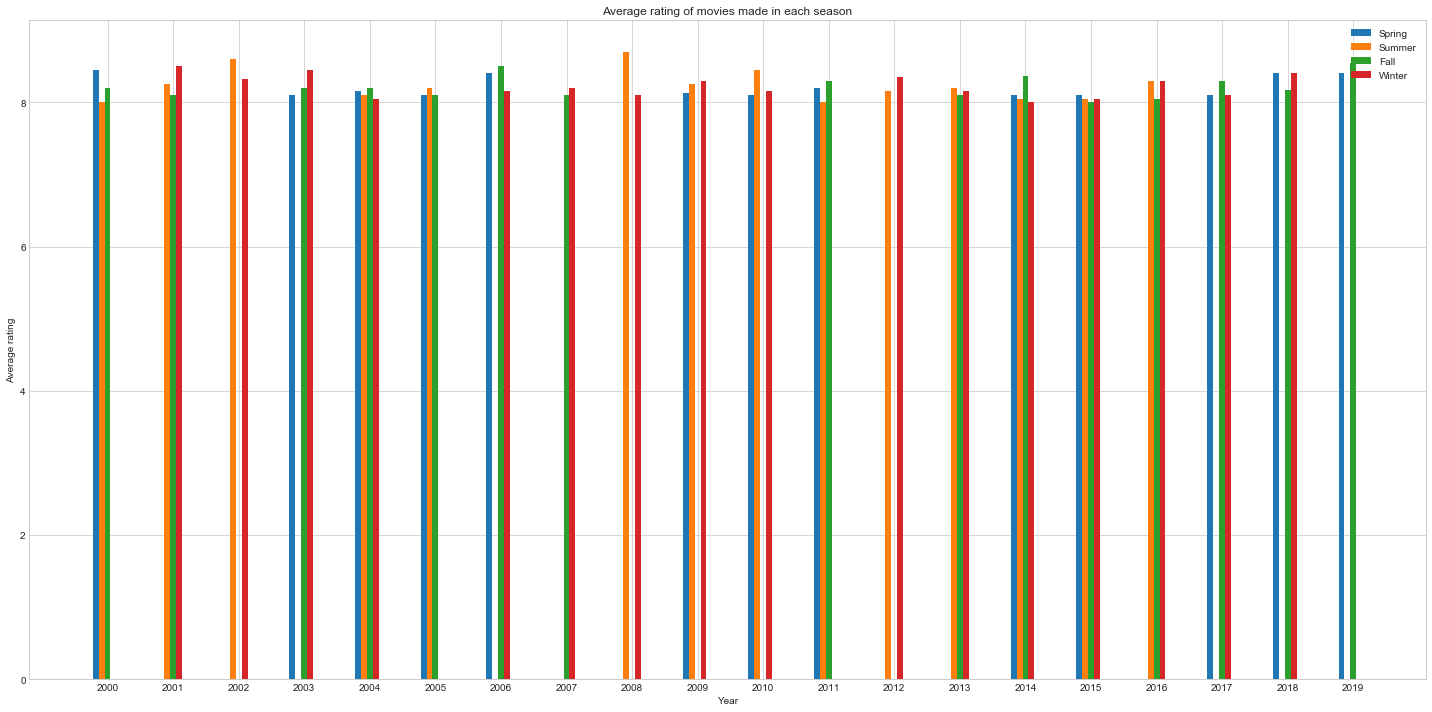

In [197]:
import numpy as np


years_array = list(df.release_year.unique())
years_array.sort()
labels = years_array

spring = []
summer = []
fall = []
winter = []

for year in labels:
    year_df = df.loc[df["release_year"] == year].copy()
    season_df = year_df.groupby("season")["rating"].mean()
    
    spring_rating = 0
    summer_rating = 0
    fall_rating = 0
    winter_rating = 0 
    for season in season_df.keys():
        if season == "spring":
            spring_rating = season_df[season]
        elif season == "summer":
            summer_rating = season_df[season]
        elif season == "fall":
            fall_rating = season_df[season]
        elif season == "winter":
            winter_rating = season_df[season]
            
    spring.append(spring_rating)
    summer.append(summer_rating)
    fall.append(fall_rating)
    winter.append(winter_rating)

x = np.arange(len(labels))  # the label locations
width = 0.09  # the width of the bars

fig, ax = plt.subplots(1)

fig.set_size_inches(20,10)
rects1 = ax.bar(x - (width * 2), spring, width, label='Spring')
rects2 = ax.bar(x - width, summer, width, label='Summer')
rects3 = ax.bar(x, fall, width, label='Fall')
rects4 = ax.bar(x + width, winter, width, label='Winter')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average rating')
ax.set_xlabel('Year')
ax.set_title('Average rating of movies made in each season')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()

## Genre and Directors

Create two pie charts in a figure next to each other. In one, plot the number of movies in each genre and in the other, plot the number of movies directed by each director. Since there are many directors only keep the people who have directed 3 movies or more. First create two dataframes for the charts. One should have two columns:
* genre (set as **index**)
* count_ratings
* mean_ratings (**sort the dataframe** by this column in decending order)

and the other one:
* name (set as **index**)
* count_movies (**sort the dataframe** by this column in decending order)

After making the dataframes you can proceed to drawing the two [pie charts](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py) based on them. Sorting the table before drawing the charts make the slices sorted, try drawing charts for the same data but comment out the line of code you wrote for sorting and see the difference. Make an appropriate title for each chart, also show the name of each genre/each director next to each pie slice. (20 points)

In [199]:
df = merged.copy()

exploded_genres = df.explode("genres").groupby("genres")

genre_stats = exploded_genres["rating"].agg([np.size, np.mean]).sort_values('size', ascending=False)
#genre_stats

In [200]:
exploded_directors = df.explode("directors").groupby("directors")

director_stats = exploded_directors["movie_name"].agg([np.size]).sort_values('size', ascending=False)
director_stats = director_stats[director_stats["size"] >= 3]
#director_stats

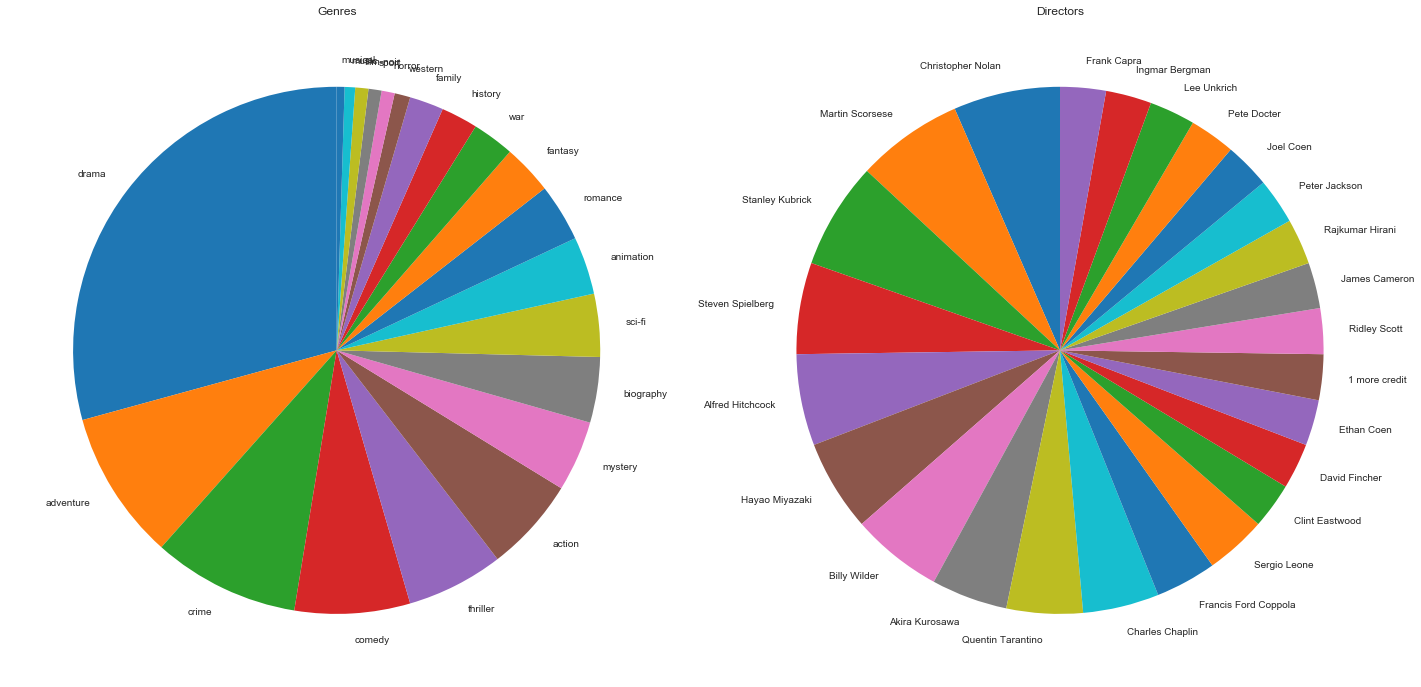

In [205]:
fig, (counts_axis, directors_axis) = plt.subplots(1, 2, figsize=(20, 10))

# create pie graph for counts
counts_axis.pie(list(genre_stats["size"]), labels=list(genre_stats.index), startangle=90)
counts_axis.set_title('Genres')

# create pie graph for directors
directors_axis.pie(list(director_stats["size"]), labels=list(director_stats.index), startangle=90)
directors_axis.set_title('Directors')
fig.tight_layout()

## Budget

Make a scatter plot with movies length and budget as the x and y axes. Since the budgets are not adjusted for inflation, to approximate that, color code the data points so that the movies that are released in the same decade have the same color. Use `alpha` parameter to make the points 50% transparent so that overlapping points are better visible. Set the proper axis labels and chart title. Also add a `colorbar` to show which color is associated with which decade. (15 points)

In [207]:
df = merged.loc[:, ('movie_name', 'release_year', 'budget', 'length')].copy()
df['decade'] = df.apply(lambda row: int(row["release_year"] / 10) * 10, axis=1)

df.drop('release_year', axis=1, inplace=True)
df

,movie_name,budget,length,decade
0,The Shawshank Redemption,25000000.0,142,1990
1,The Godfather,6000000.0,175,1970
2,The Godfather: Part II,13000000.0,202,1970
3,The Dark Knight,185000000.0,152,2000
4,12 Angry Men,350000.0,96,1950
...,...,...,...,...
247,Guardians of the Galaxy,170000000.0,121,2010
248,Mou gaan dou,6428966.0,101,2000
249,Aladdin,28000000.0,90,1990
250,La battaglia di Algeri,800000.0,121,1960


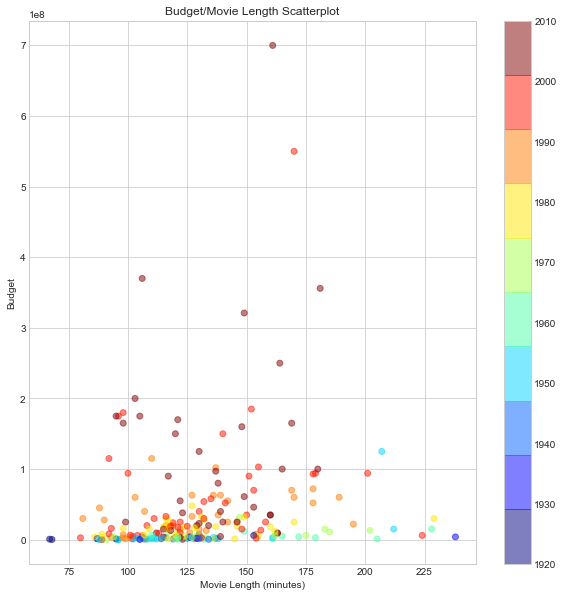

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.style.use('seaborn-whitegrid')

df = df.loc[df["budget"] < 1e9]
df = df.loc[df["length"] < 250]

number_of_unique_decades = len(df.decade.unique())
color_map = plt.get_cmap('jet', number_of_unique_decades)
scatter = ax.scatter(list(df["length"]), list(df["budget"]), c=list(df["decade"]), cmap=color_map, alpha=0.5)
ax.set_ylabel('Budget')
ax.set_xlabel('Movie Length (minutes)')
ax.set_title('Budget/Movie Length Scatterplot')
fig.colorbar(scatter)